In [237]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import shap

In [239]:
# ML Imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import partial_dependence
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_regression

In [214]:
# Warning Imports
import warnings
warnings.filterwarnings('ignore')

In [215]:
# Data Connection String:
data = "/Users/jp/Desktop/Capstone Project/Kaggle_Sirio_Libanes_ICU_Prediction.csv"
df = pd.read_csv(data, sep=',')


In [216]:
# Basic Data Information: 
print("Data Set:")
print(df.head())
print("\n")
print(df.tail())
print("\n")
print(df.info())
print("\nData Statistics:")
print(df.describe())
print(df.describe(include='all'))

Data Set:
   PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65 AGE_PERCENTIL  GENDER  \
0                         0            1          60th       0   
1                         0            1          60th       0   
2                         0            1          60th       0   
3                         0            1          60th       0   
4                         0            1          60th       0   

   DISEASE GROUPING 1  DISEASE GROUPING 2  DISEASE GROUPING 3  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   DISEASE GROUPING 4  DISEASE GROUPING 5  DISEASE GROUPING 6  ...  \
0                 0.0                 1.0                 1.0  ...   
1                 0.0                 1.0                 1.0 

In [217]:
## Data Cleaning and Preparation: 
# Check for Missing Values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values.head(20)
print(missing_values.head(20))

# Check for Duplicate Values
duplicates = df.duplicated()
has_duplicates = duplicates.any()
print("\n")
print(f"Are there any duplicate rows? {'Yes' if has_duplicates else 'No'}")
duplicate_rows = df[duplicates]

# Check Correlation between All Variables 
print("\nCorrelation Between All Variables:")
print(df.corr)


P02_VENOUS_MIN        1104
LEUKOCYTES_MAX        1104
PC02_VENOUS_MEAN      1104
PC02_VENOUS_MIN       1104
PC02_VENOUS_MAX       1104
PC02_VENOUS_DIFF      1104
PCR_MEDIAN            1104
PCR_MEAN              1104
PCR_MIN               1104
PCR_MAX               1104
PCR_DIFF              1104
PH_ARTERIAL_MEDIAN    1104
PH_ARTERIAL_MEAN      1104
PH_ARTERIAL_MIN       1104
PH_ARTERIAL_MAX       1104
PH_ARTERIAL_DIFF      1104
PH_VENOUS_MEDIAN      1104
PH_VENOUS_MEAN        1104
PH_VENOUS_MIN         1104
PH_VENOUS_MAX         1104
dtype: int64


Are there any duplicate rows? No

Correlation Between All Variables:
<bound method DataFrame.corr of       PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65 AGE_PERCENTIL  GENDER  \
0                            0            1          60th       0   
1                            0            1          60th       0   
2                            0            1          60th       0   
3                            0            1          60th       0   

In [218]:
# Preprocess Data for ML Model: 

# Drop columns with more than 50% missing values
threshold = len(df) * 0.5
df_dropped = df.dropna(thresh=threshold, axis=1)

# Separate numeric and non-numeric columns
numeric_cols = df_dropped.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = df_dropped.select_dtypes(exclude=['float64', 'int64']).columns

# Apply mean imputation to numeric columns
data_imputed = df_dropped.copy()
data_imputed[numeric_cols] = data_imputed[numeric_cols].fillna(data_imputed[numeric_cols].mean())

# Imputation for columns with fewer missing values
#data_imputed = df_dropped.fillna(df_dropped.mean())

# Create binary columns indicating whether the original data was missing
missing_indicator = df_dropped.isnull().astype(int)
missing_indicator.columns = [f"{col}_MISSING" for col in missing_indicator.columns]

# Combine the imputed data with the missing indicators
df_final = pd.concat([data_imputed, missing_indicator], axis=1)

# Identify non-numeric columns that need encoding 
non_numeric_cols = ['AGE_PERCENTIL', 'GENDER', 'WINDOW']
# Apply one-hot encoding to these columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = pd.DataFrame(encoder.fit_transform(df_final[non_numeric_cols]),
                                columns=encoder.get_feature_names_out(non_numeric_cols)) 
# Drop original non-numeric columns from the dataset and concatenate encoded features
df_encoded = pd.concat([df_final.drop(columns=non_numeric_cols), encoded_features], axis=1)

# Display the shape of the final dataset and the first few rows to verify
df_final_shape = df_final.shape
df_final_head = df_final.head()

df_final_shape, df_final_head

# Select features and target variable
X = df_encoded.drop(columns=['ICU', 'PATIENT_VISIT_IDENTIFIER', 'ICU_MISSING'])
y = df_encoded['ICU']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Selection: Using Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
classification_rep = classification_report(y_test, y_pred)

#accuracy, roc_auc, classification_rep
print("\nAccuracy Score:")
print(accuracy)
print("\nROC AUC Score:")
print(roc_auc)
print("\nClassification Report:")
print(classification_rep)



Accuracy Score:
0.8615916955017301

ROC AUC Score:
0.8823684789786485

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       413
           1       0.83      0.64      0.73       165

    accuracy                           0.86       578
   macro avg       0.85      0.80      0.82       578
weighted avg       0.86      0.86      0.86       578



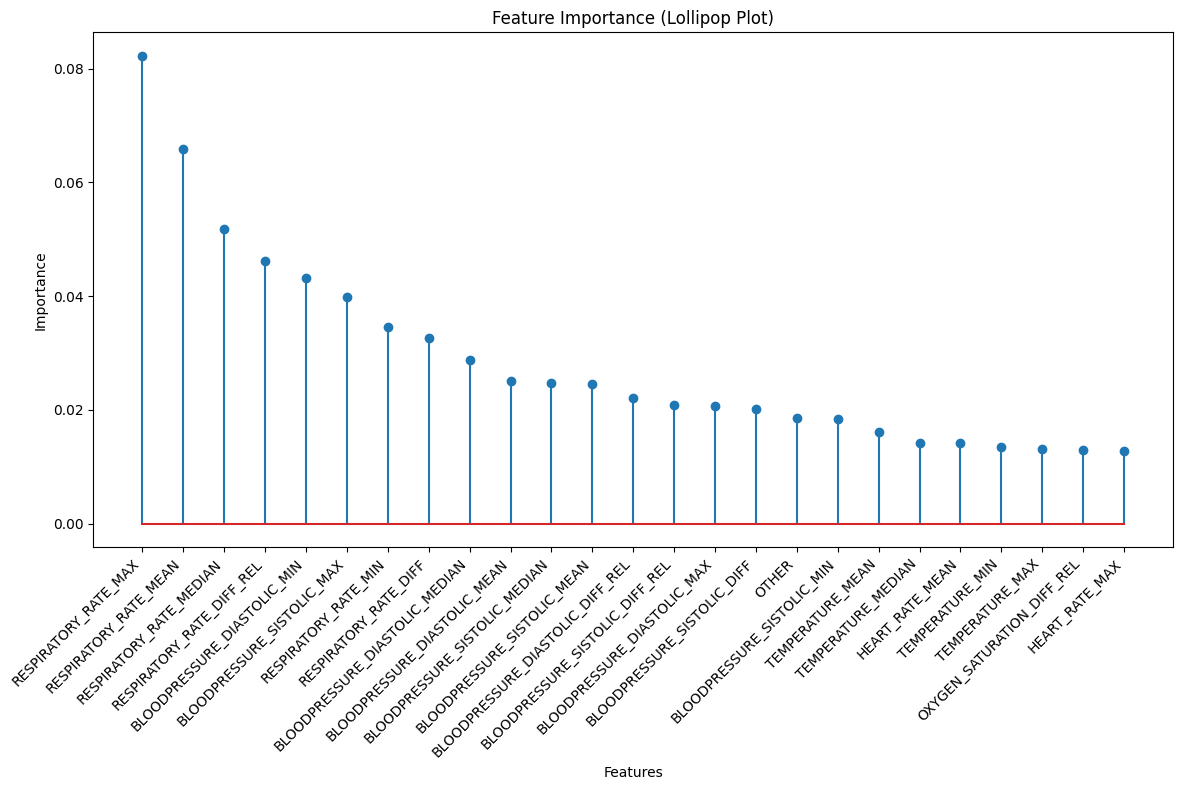

In [258]:
## Data Visualizations: 
# Feature Importance (Lollipop Plot)
importances = model.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

top_n = 25
top_features = features[indices][:top_n]
top_importances = importances[indices][:top_n]

# Lollipop Plot: 
plt.figure(figsize=(12, 8))
plt.stem(top_features, top_importances)
plt.title("Feature Importance (Lollipop Plot)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

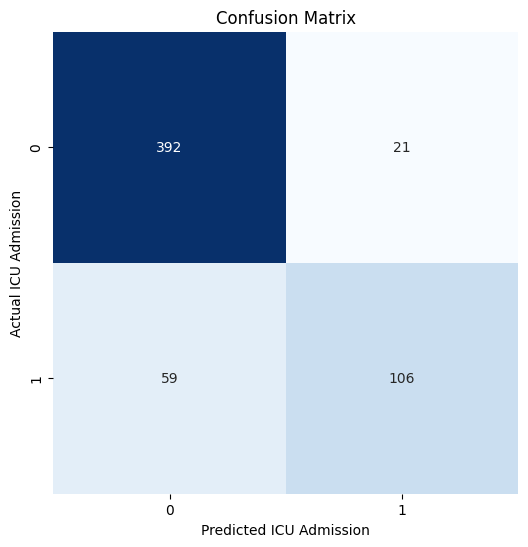

In [220]:
# Confusion Matrix (Heatmap)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual ICU Admission")
plt.xlabel("Predicted ICU Admission")
plt.show()

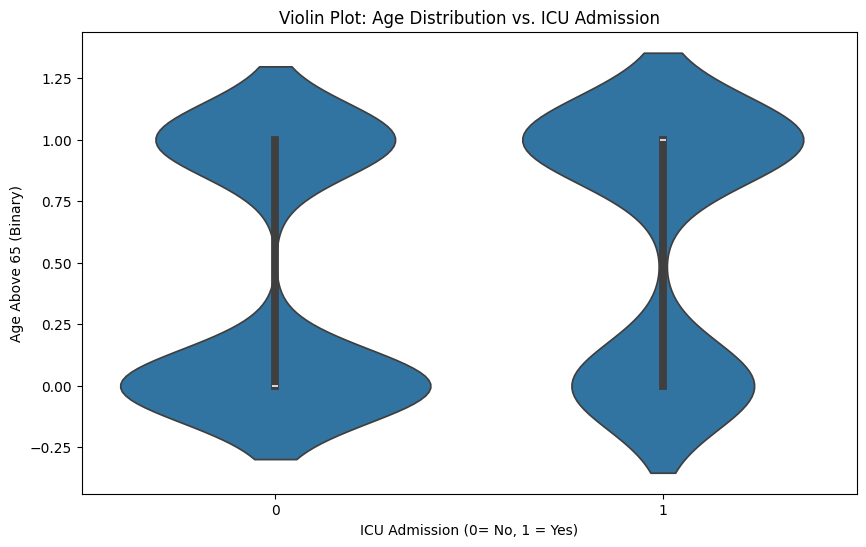

In [221]:
# Violin Plot (ICU Admission vs. Age)
plt.figure(figsize=(10, 6))
sns.violinplot(x=y_test, y=X_test['AGE_ABOVE65'])
plt.title("Violin Plot: Age Distribution vs. ICU Admission")
plt.xlabel("ICU Admission (0= No, 1 = Yes)")
plt.ylabel("Age Above 65 (Binary)")
plt.show()

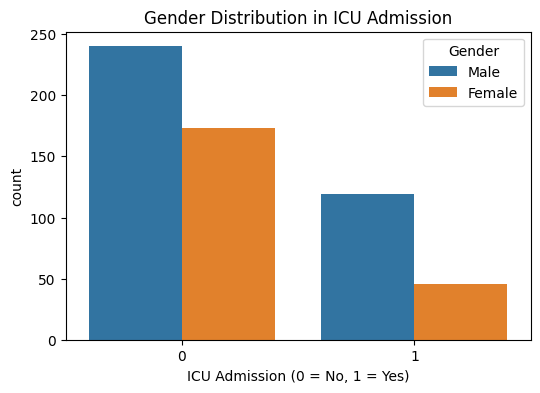

In [222]:
# Gender Distribution (Bar Plot)
plt.figure(figsize=(6, 4))
sns.countplot(x=y_test, hue=X_test['GENDER_1'])
plt.title("Gender Distribution in ICU Admission")
plt.xlabel("ICU Admission (0 = No, 1 = Yes)")
plt.legend(title="Gender", loc='upper right', labels=['Male', 'Female'])
plt.show()

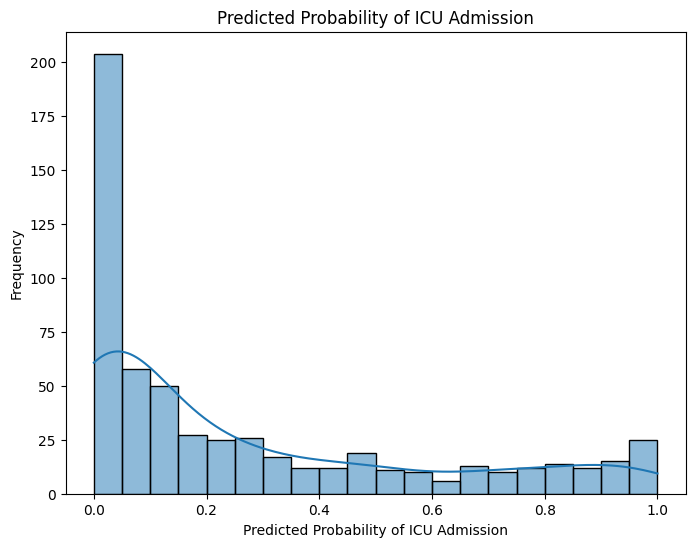

In [223]:
# Predicted Probability of ICU Admission (Histogram)
plt.figure(figsize=(8, 6))
sns.histplot(y_prob, bins=20, kde=True)
plt.title("Predicted Probability of ICU Admission")
plt.xlabel("Predicted Probability of ICU Admission")
plt.ylabel("Frequency")
plt.show()

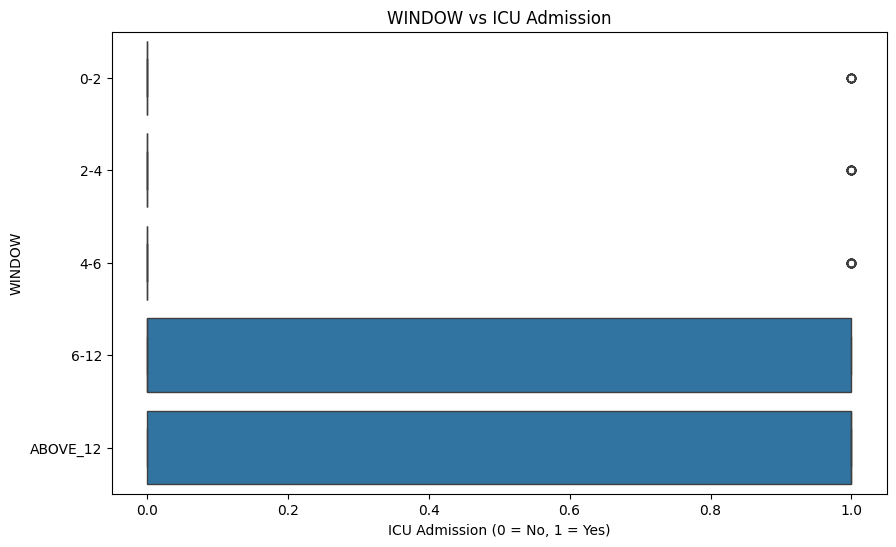

In [256]:
# Box Plot (ICU Admission vs. WINDOW): 
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_test, y='WINDOW', data=df_final)
plt.title("WINDOW vs ICU Admission")
plt.xlabel("ICU Admission (0 = No, 1 = Yes)")
plt.ylabel("WINDOW")
plt.show()

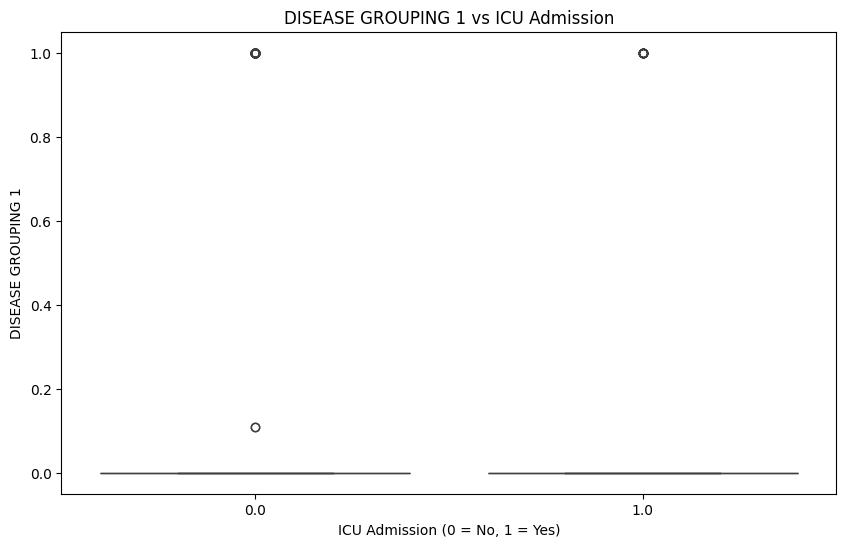

In [260]:
# Box Plot for 'balance' Feature
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_test, y='DISEASE GROUPING 1', data=df_final)
plt.title("DISEASE GROUPING 1 vs ICU Admission")
plt.xlabel("ICU Admission (0 = No, 1 = Yes)")
plt.ylabel('DISEASE GROUPING 1')
plt.show()

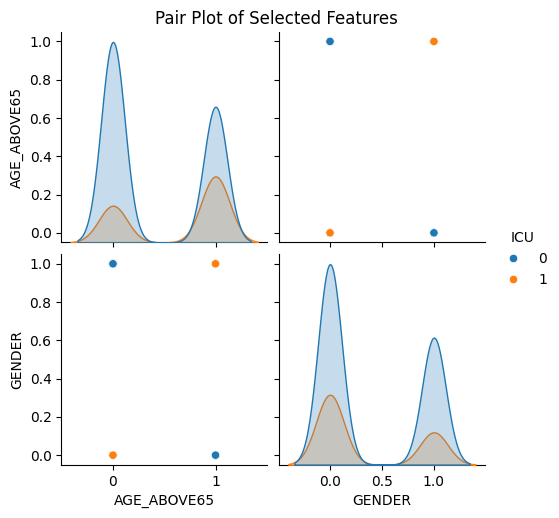

In [242]:
# 7. Pair Plot (for Selected Features)
# Select Important Features 
selected_features = ['AGE_ABOVE65', 'GENDER', 'WINDOW', 'ICU']
df_subset = df[selected_features]
sns.pairplot(df_subset, hue='ICU', diag_kind='kde')
# Plot pairplot 
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

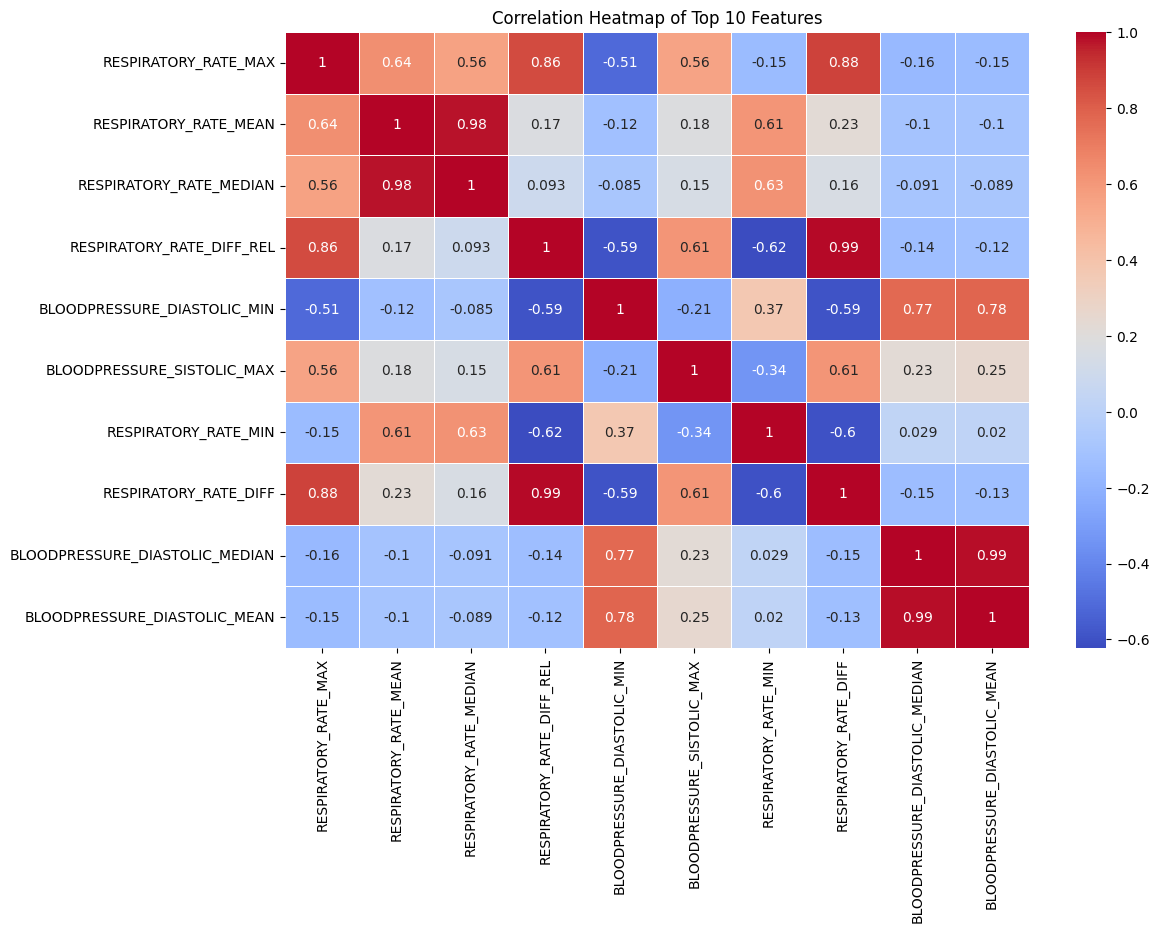

In [226]:
# Correlation Heatmap:
top_features = X_test.columns[importances.argsort()[::-1][:10]]

plt.figure(figsize=(12, 8))
corr_matrix = df_encoded.corr() 
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Top 10 Features")
plt.show()

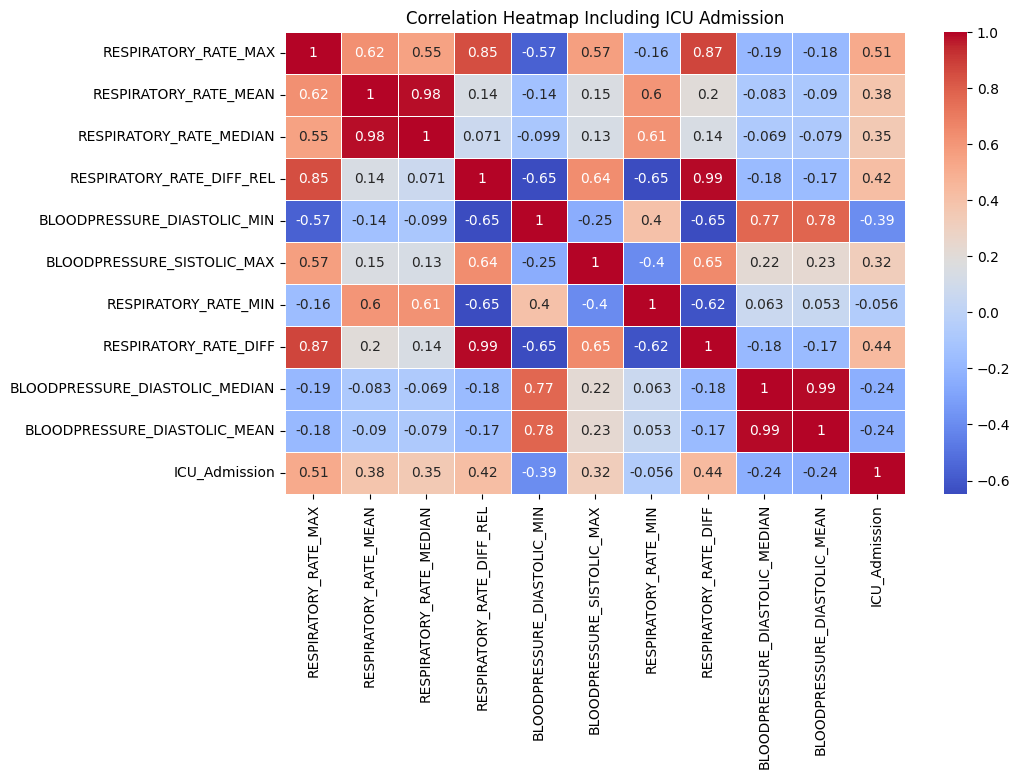

In [227]:
# Assuming 'ICU' is the target variable (0 = No ICU, 1 = ICU), and X_test contains the features
X_test_with_icu = X_test.copy()  # Copy feature data
X_test_with_icu['ICU_Admission'] = y_test  # Add ICU admission as a column

# Calculate the correlation matrix, now including 'ICU_Admission'
corr_matrix_with_icu = X_test_with_icu.corr()

# Select top N important features along with 'ICU_Admission' for the heatmap
top_features_with_icu = list(top_features) + ['ICU_Admission']

# Create the correlation heatmap including ICU admission
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_with_icu.loc[top_features_with_icu, top_features_with_icu], 
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap Including ICU Admission")
plt.show()


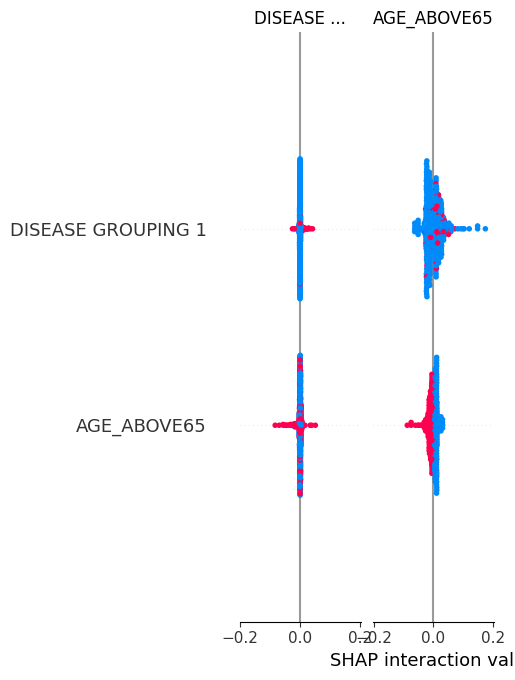

In [228]:
# 10. SHAP Value Summary Plot 
#Explain the model's predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

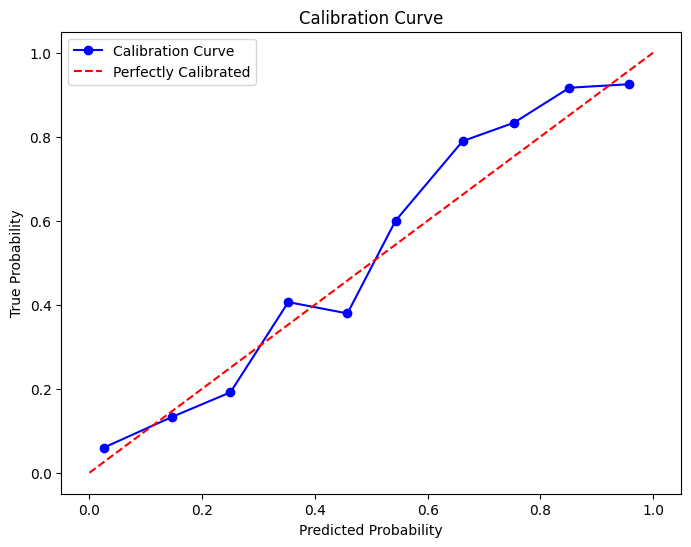

In [ ]:
## ML Visuals

# 1. Calibration Curve
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', color='blue', label="Calibration Curve")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Perfectly Calibrated")
plt.title("Calibration Curve")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()
plt.show()


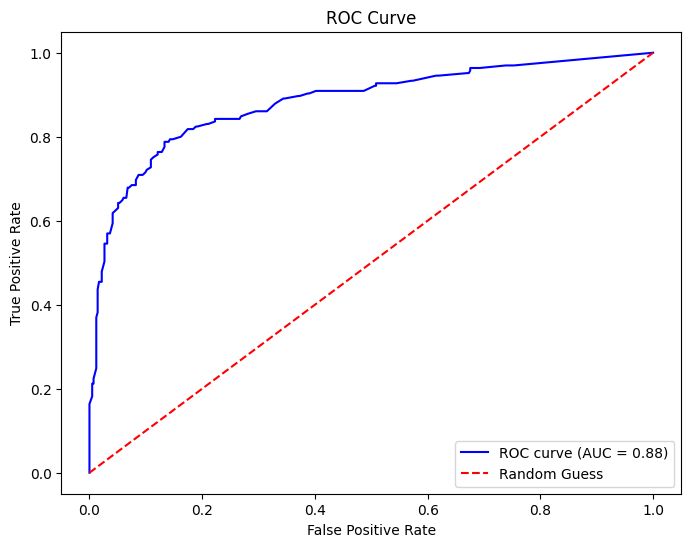

In [ ]:
# 2. ROC Curve
# Generate ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

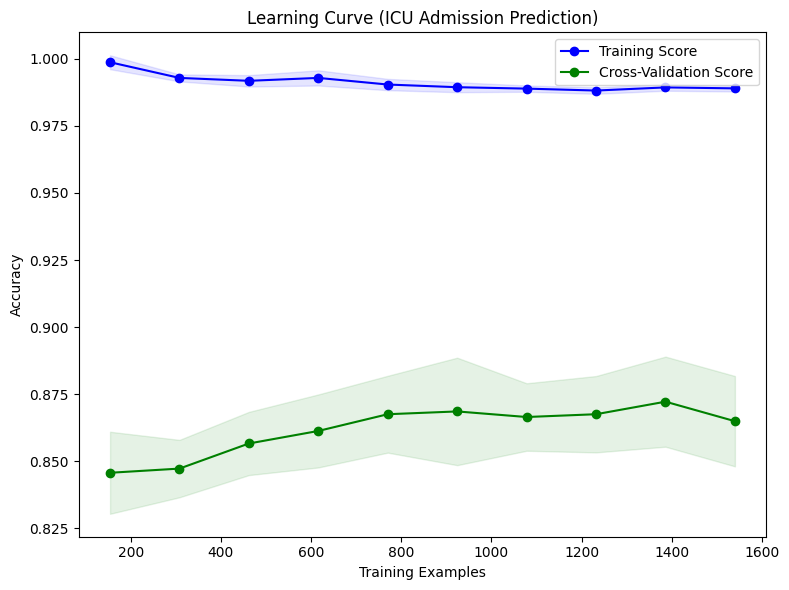

In [ ]:
# 3. Learning Curve 
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-Validation Score")

# Fill between the lines for standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")

plt.title("Learning Curve (ICU Admission Prediction)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()
plt.show()